<a href="https://colab.research.google.com/github/RautRitesh/langgraph/blob/main/Human_in_the_loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install langchain langchain-groq langgraph langchain-community langchain-tavily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.2 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


##Human in the loop👱➿➿ can be implemented using langgraph inbuilt classes as well as by the custom logic. For today I will be going with custom logic

##Step1: Importing all the required packages and the tools


In [200]:
from langchain_groq import ChatGroq
from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from typing import TypedDict, Annotated, Literal
import operator
from langchain_core.messages import AnyMessage, ToolMessage
from langgraph.graph import StateGraph, MessagesState, START, END

In [70]:
from google.colab import userdata
tavily_api_key=userdata.get('Tavily_api_key')
api_key=userdata.get('groq_api_key')

In [71]:
llm=ChatGroq(model="openai/gpt-oss-20b", api_key=api_key)

##Step2:Setting up the tools

In [72]:
@tool
def multiply(a,b):
  """This is a tool for multiplying two numbers"""
  return a*b



In [73]:
search_tool=TavilySearch(max_results=2,tavily_api_key=tavily_api_key)

In [74]:
@tool
def search(query:str):
  """This  is a tavily search tool used to search the internet for information"""
  response=search_tool.invoke(query)
  return response

In [75]:
tools=[multiply, search]

In [76]:
llm_with_tools=llm.bind_tools(tools=tools)

### Custom logic for invoking the tools by ourself and understanding how the llm_with_tools given response👏👏👏⚒️⚒️


In [77]:
response=[llm_with_tools.invoke("who is pm of Koshi province nepal?")]

In [78]:
print(response[-1])

content='' additional_kwargs={'reasoning_content': 'We need to answer: "who is pm of Koshi province Nepal?" We should provide current information. As of 2026, we need up-to-date. Likely the province\'s chief minister is from Nepali Congress or CPN. Let\'s search.', 'tool_calls': [{'id': 'fc_5aa7792e-5c34-4acf-82fd-20d947d38452', 'function': {'arguments': '{"query":"Koshi province chief minister 2026"}', 'name': 'search'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 165, 'total_tokens': 247, 'completion_time': 0.082611348, 'completion_tokens_details': {'reasoning_tokens': 53}, 'prompt_time': 0.007920842, 'prompt_tokens_details': None, 'queue_time': 0.003439234, 'total_time': 0.09053219}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_92d51d08e5', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'} id='lc_run--019bcc37-9dbc-7092-b431-c88bab5262dc-0' tool_calls=[{'name

In [79]:
tool_mapping={tool.name:tool for tool in tools}

In [80]:
print(tool_mapping)

{'multiply': StructuredTool(name='multiply', description='This is a tool for multiplying two numbers', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x7df7046844a0>), 'search': StructuredTool(name='search', description='This  is a tavily search tool used to search the internet for information', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x7df704685080>)}


In [81]:
tool_details=response[-1].additional_kwargs.get("tool_calls",[])
if len(tool_details):
  function=tool_details[0]
  print(function)
  name=tool_details[0].get('function').get('name')
  query=tool_details[0].get('function').get('arguments')
  response=tool_mapping[name].invoke(query)

  print("\n--")
  print(name)
  print(query)
  print("final response from tools---")
  print(response)
else:
  print("no tool calls")

{'id': 'fc_5aa7792e-5c34-4acf-82fd-20d947d38452', 'function': {'arguments': '{"query":"Koshi province chief minister 2026"}', 'name': 'search'}, 'type': 'function'}

--
search
{"query":"Koshi province chief minister 2026"}
final response from tools---
{'query': '{query:Koshi province chief minister 2026}', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://simple.wikipedia.org/wiki/Chief_Minister_of_Koshi_Province', 'title': 'Chief Minister of Koshi Province - Simple Wikipedia', 'content': 'Chief Minister of Koshi Province ; Incumbent Hikmat Kumar Karki since 9 May 2024. Government of Koshi Province ; Incumbent Hikmat Kumar Karki since 9 May 2024.', 'score': 0.9999825, 'raw_content': None}, {'url': 'https://en.wikipedia.org/wiki/Chief_Minister_of_Koshi_Province', 'title': 'Chief Minister of Koshi Province - Wikipedia', 'content': "The current chief minister is CPN (Unified Marxist-Leninist)' Hikmat Kumar Karki, in office since 9 May 2024.", 'score':

## Step3: Now based on the `response given by llm` and `its understanding of how output is produced` now let us go with the creation of nodes.Remember that the `tool_mapping`🛠️:🗺️ was used because it store the information about our tools especially `tool object` that can  be invoked otherwise we could not do so , Hence the tool_mapping is important

In [142]:
def agent(state:MessagesState):
  message=state["messages"]
  response=llm_with_tools.invoke(message)
  print("From the agent")
  print(response)
  return {"messages":[response]}

In [143]:
agent({"messages":["Who is the current Prime minister of Nepa?"]})

From the agent
content='' additional_kwargs={'reasoning_content': 'User asks: "Who is the current Prime minister of Nepa?" Likely typo: Nepal. Need current PM of Nepal. As of 2026 Jan? As of 2024, PM is Pushpa Kamal Dahal (also known as Prachanda). Actually Nepal had PM Sher Bahadur Deuba, then Dahal, then Deuba again? Let\'s check. In 2022, Dahal was PM until 2023, then Deuba. In 2024, Deuba was PM. In 2025, maybe a new PM. We need up-to-date info. Let\'s search.', 'tool_calls': [{'id': 'fc_2d5c3e4d-de61-4cd6-814f-be345381b0fe', 'function': {'arguments': '{"query":"current Prime Minister of Nepal 2026"}', 'name': 'search'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 155, 'prompt_tokens': 165, 'total_tokens': 320, 'completion_time': 0.174509497, 'completion_tokens_details': {'reasoning_tokens': 126}, 'prompt_time': 0.007918768, 'prompt_tokens_details': None, 'queue_time': 0.002989777, 'total_time': 0.182428265}, 'model_name': 'openai/gpt-oss-20b', 'sy

{'messages': [AIMessage(content='', additional_kwargs={'reasoning_content': 'User asks: "Who is the current Prime minister of Nepa?" Likely typo: Nepal. Need current PM of Nepal. As of 2026 Jan? As of 2024, PM is Pushpa Kamal Dahal (also known as Prachanda). Actually Nepal had PM Sher Bahadur Deuba, then Dahal, then Deuba again? Let\'s check. In 2022, Dahal was PM until 2023, then Deuba. In 2024, Deuba was PM. In 2025, maybe a new PM. We need up-to-date info. Let\'s search.', 'tool_calls': [{'id': 'fc_2d5c3e4d-de61-4cd6-814f-be345381b0fe', 'function': {'arguments': '{"query":"current Prime Minister of Nepal 2026"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 155, 'prompt_tokens': 165, 'total_tokens': 320, 'completion_time': 0.174509497, 'completion_tokens_details': {'reasoning_tokens': 126}, 'prompt_time': 0.007918768, 'prompt_tokens_details': None, 'queue_time': 0.002989777, 'total_time': 0.182428265}, 'model_name': 'openai/gpt-os

In [189]:
import json

In [181]:
def router(state:MessagesState)->Literal["tool_calls",END]:
  last_message=state["messages"][-1]
  if last_message.additional_kwargs.get("tool_calls"):
    return "tool_calls"
  else:
    return END

In [208]:
def invoke_tool(state:MessagesState):
  last_message=state["messages"][-1].additional_kwargs.get("tool_calls")[0]
  if len(last_message):
    tool_name=last_message.get("function").get("name")
    tool_id=last_message.get("id")
    tool_argument=last_message.get("function").get("arguments")
    tool_argument_query=json.loads(tool_argument)
    actual_query=tool_argument_query.get("query","")
    if tool_name=="search":
      human_input=input("Do you want me to use the tavily search it will cost you[Y/N]:")
      if human_input.lower()=="y":
        response=tool_mapping[tool_name].invoke(actual_query)

        return {"messages":[ToolMessage(tool_call_id=tool_id,content=str(response),name=tool_name)]}
      else:
        return {"messages":[ToolMessage(tool_call_id=tool_id,content="User declined tool calls",name=tool_name)]}

  else:
    raise Exception("tool was not found")


In [209]:
workflow=StateGraph(MessagesState)
workflow.add_node("agent",agent)
workflow.add_node("tools",invoke_tool)
workflow.add_conditional_edges("agent",router,{"tool_calls":"tools",END:END})
workflow.add_edge("tools","agent")
workflow.add_edge(START,"agent")
app=workflow.compile()

In [210]:
from IPython.display import Image,display

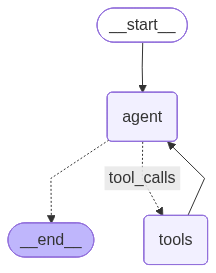

In [211]:
display(Image(app.get_graph().draw_mermaid_png()))

In [213]:
while True:
  query=input("Enter your question to ask or enter exit to quit:")



From the agent
content='' additional_kwargs={'reasoning_content': 'The user asks: "who is the prime minister of Nepa?" Probably a typo, meaning Nepal. The answer: as of 2026, Nepal\'s Prime Minister is Pushpa Kamal Dahal (Prachanda). Wait: Actually, Nepal\'s prime minister changed recently. Let\'s recall: In 2023, Pushpa Kamal Dahal became prime minister again. He was PM from 2008-2011 and then again from 2020-2021, then again from 2023. As of 2026, likely still him. Let\'s double-check with up-to-date info. Use search tool.', 'tool_calls': [{'id': 'fc_bd912a3f-87c9-4fbe-861d-2dbdce82ae4b', 'function': {'arguments': '{"query":"current prime minister of Nepal 2026"}', 'name': 'search'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 157, 'prompt_tokens': 164, 'total_tokens': 321, 'completion_time': 0.171213164, 'completion_tokens_details': {'reasoning_tokens': 128}, 'prompt_time': 0.007966293, 'prompt_tokens_details': None, 'queue_time': 0.003259803, 'tota

{'messages': [HumanMessage(content='who is the prime minister of Nepa?', additional_kwargs={}, response_metadata={}, id='dacb7bad-da9a-45b2-9317-56e695b29ace'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'The user asks: "who is the prime minister of Nepa?" Probably a typo, meaning Nepal. The answer: as of 2026, Nepal\'s Prime Minister is Pushpa Kamal Dahal (Prachanda). Wait: Actually, Nepal\'s prime minister changed recently. Let\'s recall: In 2023, Pushpa Kamal Dahal became prime minister again. He was PM from 2008-2011 and then again from 2020-2021, then again from 2023. As of 2026, likely still him. Let\'s double-check with up-to-date info. Use search tool.', 'tool_calls': [{'id': 'fc_bd912a3f-87c9-4fbe-861d-2dbdce82ae4b', 'function': {'arguments': '{"query":"current prime minister of Nepal 2026"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 157, 'prompt_tokens': 164, 'total_tokens': 321, 'completion_time': 